In [ ]:
!pip install folium leafmap

In [1]:
import urllib
import json

import numpy as np
import pandas as pd

from shapely.geometry import shape

import folium
from folium.plugins import Draw
from folium.plugins.treelayercontrol import TreeLayerControl

import leafmap

from IPython.display import JSON

## 1) Input definition

In [2]:
start_date = '2024-01-01'
end_date = '2025-01-30'

### Define an area of interest by drawing in the map using the rectangle selection tool

In [3]:
m = leafmap.Map(center=(47.005, 11.507), zoom=7.5)
m

Map(center=[47.005, 11.507], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [5]:
feat = m.draw_features
geom_dict = feat[0]['geometry']
geom = shape(geom_dict)
geom.wkt

'POLYGON ((11.299438 46.456182, 11.299438 46.51717, 11.438828 46.51717, 11.438828 46.456182, 11.299438 46.456182))'

### Alternatively upload your area of interest

## 2) Retrieve the bursts info with https request

In [6]:
https_request = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Bursts?$filter=" + urllib.parse.quote(
    f"ContentDate/Start ge {start_date}T00:00:00.000Z and ContentDate/Start le {end_date}T23:59:59.000Z and "
    f"PolarisationChannels eq 'VV' and "
    f"OData.CSC.Intersects(area=geography'SRID=4326;{geom.wkt}')"
) + "&$top=1000"

with urllib.request.urlopen(https_request) as response:
    content = response.read().decode()
bursts = json.loads(content)
JSON(bursts)

<IPython.core.display.JSON object>

In [7]:
bursts_uniqueTrack = {}
burstId_list = []
track_list = []
for b in bursts['value']:
    if b['RelativeOrbitNumber'] not in track_list:
        bursts_uniqueTrack[b['RelativeOrbitNumber']] = {}
        track_list.append(b['RelativeOrbitNumber'])
    burstId_subswath = f"BurstId: {b['BurstId']}, {b['SwathIdentifier']}"
    if burstId_subswath not in burstId_list:
        bursts_uniqueTrack[b['RelativeOrbitNumber']][burstId_subswath] = b['GeoFootprint']['coordinates']
        burstId_list.append(burstId_subswath)

## 3) Show on map

In [8]:
# Initialize the map and center it in the middle of the bursts

lat, lon = [], []
for burst in bursts_uniqueTrack.values():
    for coords in burst.values():
        lat = lat + [c[1] for c in coords[0]]
        lon = lon + [c[0] for c in coords[0]]
        
m = folium.Map(
    location=[np.mean([max(lat), min(lat)]), np.mean([max(lon), min(lon)])],
    zoom_start=8
)


# Add the area of interest

if geom.geom_type == 'Point':
    folium.Marker([geom.y, geom.x]).add_to(m)

if geom.geom_type == 'Polygon':
    folium.Polygon(
        locations=[(y, x) for x, y in geom.exterior.coords],
        color='blue',
        fill=True,            
        fill_color='blue',    
        fill_opacity=0.4
    ).add_to(m)


# Add each burst grouped by track

children = []

for track, burst in bursts_uniqueTrack.items():
    
    children.append(
        {
            "label": f"Track {track}",
            "select_all_checkbox": True,
            "children": [{"label":str(b), "layer": folium.Polygon(locations=np.flip(np.squeeze(p), axis=1), color='red').add_to(m)} for b, p in burst.items()]
        }
    )


# Show the map

overlay_tree = {
    "label": "Burst Footprints",
    "select_all_checkbox": "Un/select all",
    "children": children
}

TreeLayerControl(overlay_tree=overlay_tree).add_to(m)

m

## 4) Plot calendar

In [9]:
import calendar
import matplotlib.pyplot as plt

def display_calendar(year, month, highlighted_dates={}):

    cal = calendar.monthcalendar(year, month)
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.set_xticks([])
    ax.set_yticks([])
                
    for row, week in enumerate(cal):
        for col, day in enumerate(week):
            if day == 0:
                continue
            color = highlighted_dates.get(day, "white")
            ax.add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, color=color, alpha=0.6))
            ax.text(col, row, str(day), ha="center", va="center", fontsize=12, weight='bold')

    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(len(cal) - 0.5, -0.5)
    ax.set_title(calendar.month_name[month] + f" {year}")
    plt.show()

In [10]:
date, track = [], [] 
for b in bursts['value']:
    date.append(b['BeginningDateTime'])
    track.append(b['RelativeOrbitNumber'])
df = pd.DataFrame(data={'date': date, 'track': track})
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop_duplicates(subset=['track', 'year', 'month', 'day'])
df = df.sort_values(by='date', ascending=True)

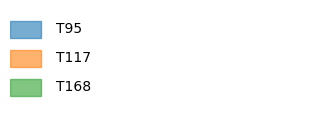

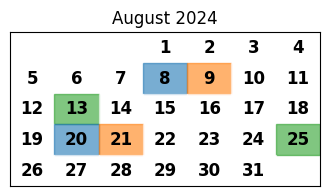

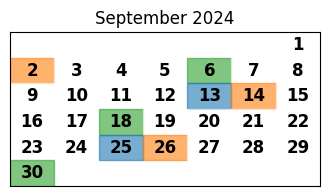

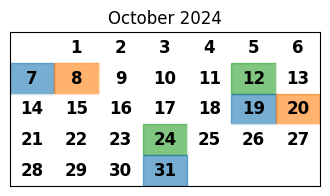

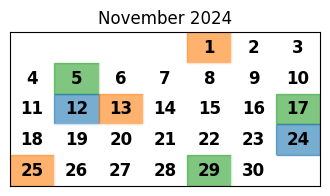

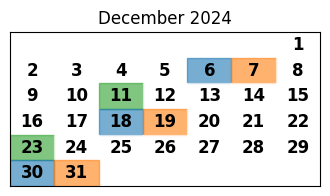

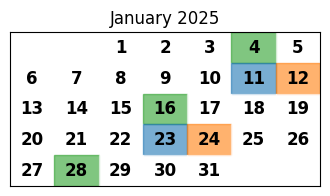

In [11]:
color_track = {}
fig, ax = plt.subplots(figsize=(4, len(df['track'].unique())*0.5))
for i, t in enumerate(df['track'].unique()):
    color_track[t] = f'C{i}'
    ax.add_patch(plt.Rectangle((0, -i*0.5), 0.1, 0.3, color=color_track[t], alpha=0.6))
    ax.text(0.15, -i*0.5+0.1, f'T{t}', fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(-len(df['track'].unique())*0.5, 0.5)
ax.axis('off')
plt.show()

for year in df['year'].unique():
    df_year = df.loc[df['year'] == year, :]
    for month in df_year['month'].unique():
        h = {}
        for i, row in df_year.loc[df_year['month'] == month, :].iterrows():
            h[row['day']] = color_track[row['track']]
        display_calendar(year, month, h)

## 5) Get perpendicular baselines

Select one of the available sub_swath_identifier (i.e. iw1, iw2, iw3) and burstId from the following list or from the map widget above.

In [12]:
for x in children:
  print(x["label"])
  for y in x["children"]:
    print("  " + y["label"]) 

Track 95
  BurstId: 202704, IW3
  BurstId: 202703, IW3
Track 117
  BurstId: 249433, IW2
  BurstId: 249434, IW2
Track 168
  BurstId: 359502, IW1
  BurstId: 359501, IW1


Set the required polarization, subswath identifier and correspondant burst id.

In [13]:
track
sub_swath_identifier = "iw2"
burst_id = "249433"
polarization = "VV"

Get the product names of which we need to download the metadata

In [14]:
SAFE_image_list = []
S3_image_list = []
for b in bursts['value']:
    if b['SwathIdentifier'].lower() == sub_swath_identifier:
        if str(b["BurstId"]) == str(burst_id):
            if b["ParentProductName"] not in SAFE_image_list:
                SAFE_image_list.append((b["ParentProductName"]))
                S3_image_list.append((b["S3Path"].split(".SAFE")[0] + ".SAFE"))

Get the metadata from the S3 bucket (add your CDSE S3 credentials)

In [15]:
import os
os.environ["AWS_ACCESS_KEY_ID"] = "CXJ4X1DAG8XKQEHFXQNJ"
os.environ["AWS_SECRET_ACCESS_KEY"] = "UnLZIoFCkDABJhqbOhirpdO7cgQT9JLw575iKBhA"

if polarization.lower()=="vv":
    include_pol='vv'
    exclude_pol='vh'
elif polarization.lower()=="vh":
    include_pol='vh'
    exclude_pol='vv'

s3_endpoint = "eodata.dataspace.copernicus.eu"

for im_safe, im_s3 in zip(SAFE_image_list,S3_image_list):
    print(im_safe)
    os.system(f"s5cmd --endpoint-url \"https://{s3_endpoint}\" cp --include \"*{sub_swath_identifier.lower()}*\" --exclude \"*{exclude_pol}*\"  --exclude \"*.tiff\" --include \"manifest.safe\" \"s3:/\"{im_s3}\"/*\" {im_safe}/")
    os.system(f"mkdir {im_safe}/measurement")

    command = f"s5cmd --endpoint-url \"https://{s3_endpoint}\" -r 5 ls \"s3:/\"{im_s3}\"/measurement/\" | grep -o '\S\+$' | grep {include_pol} | grep {sub_swath_identifier.lower()}"
    result = os.popen(command).read().splitlines()

    for im in result:
        command = f"gdal_create -ot Int8 -outsize 1 1 -bands 1 -burn 0 {im_safe}/measurement/{im}"
        os.system(command)

S1A_IW_SLC__1SDV_20240821T170720_20240821T170747_055314_06BE95_CC41.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/08/21/S1A_IW_SLC__1SDV_20240821T170720_20240821T170747_055314_06BE95_CC41.SAFE/annotation/calibration/calibration-s1a-iw2-slc-vv-20240821t170722-20240821t170747-055314-06be95-005.xml S1A_IW_SLC__1SDV_20240821T170720_20240821T170747_055314_06BE95_CC41.SAFE/annotation/calibration/calibration-s1a-iw2-slc-vv-20240821t170722-20240821t170747-055314-06be95-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/08/21/S1A_IW_SLC__1SDV_20240821T170720_20240821T170747_055314_06BE95_CC41.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20240821t170722-20240821t170747-055314-06be95-005.xml S1A_IW_SLC__1SDV_20240821T170720_20240821T170747_055314_06BE95_CC41.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20240821t170722-20240821t170747-055314-06be95-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/08/21/S1A_IW_SLC__1SDV_20240821T170720_20240821T170747_055314_06BE95_CC41.SAFE/ma

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20240821T170720_20240821T170747_055314_06BE95_CC41.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20240902T170720_20240902T170747_055489_06C515_EEB7.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/09/02/S1A_IW_SLC__1SDV_20240902T170720_20240902T170747_055489_06C515_EEB7.SAFE/annotation/calibration/calibration-s1a-iw2-slc-vv-20240902t170722-20240902t170747-055489-06c515-005.xml S1A_IW_SLC__1SDV_20240902T170720_20240902T170747_055489_06C515_EEB7.SAFE/annotation/calibration/calibration-s1a-iw2-slc-vv-20240902t170722-20240902t170747-055489-06c515-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/09/02/S1A_IW_SLC__1SDV_20240902T170720_20240902T170747_055489_06C515_EEB7.SAFE/manifest.safe S1A_IW_SLC__1SDV_20240902T170720_20240902T170747_055489_06C515_EEB7.SAFE/manifest.safe
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/09/02/S1A_IW_SLC__1SDV_20240902T170720_20240902T170747_055489_06C515_EEB7.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20240902t170722-20240902t170747-055489-06c515-005.xml S1A_IW_SLC__1SDV_20240902T170720_20240902T170747_055489_06C515_EEB7.SAFE/annotatio

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20240902T170720_20240902T170747_055489_06C515_EEB7.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20240809T170720_20240809T170746_055139_06B839_A6A0.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/08/09/S1A_IW_SLC__1SDV_20240809T170720_20240809T170746_055139_06B839_A6A0.SAFE/manifest.safe S1A_IW_SLC__1SDV_20240809T170720_20240809T170746_055139_06B839_A6A0.SAFE/manifest.safe
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/08/09/S1A_IW_SLC__1SDV_20240809T170720_20240809T170746_055139_06B839_A6A0.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20240809t170721-20240809t170746-055139-06b839-005.xml S1A_IW_SLC__1SDV_20240809T170720_20240809T170746_055139_06B839_A6A0.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20240809t170721-20240809t170746-055139-06b839-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/08/09/S1A_IW_SLC__1SDV_20240809T170720_20240809T170746_055139_06B839_A6A0.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20240809t170721-20240809t170746-055139-06b839-005.xml S1A_IW_SLC__1SDV_20240809T170720_20240809T170746_055139_06B839_A6A0.SAFE/annotation/calibration/noise-s1

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20240809T170720_20240809T170746_055139_06B839_A6A0.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20240914T170721_20240914T170748_055664_06CBFF_A704.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/09/14/S1A_IW_SLC__1SDV_20240914T170721_20240914T170748_055664_06CBFF_A704.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20240914t170722-20240914t170748-055664-06cbff-005.xml S1A_IW_SLC__1SDV_20240914T170721_20240914T170748_055664_06CBFF_A704.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20240914t170722-20240914t170748-055664-06cbff-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/09/14/S1A_IW_SLC__1SDV_20240914T170721_20240914T170748_055664_06CBFF_A704.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20240914t170722-20240914t170748-055664-06cbff-005.xml S1A_IW_SLC__1SDV_20240914T170721_20240914T170748_055664_06CBFF_A704.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20240914t170722-20240914t170748-055664-06cbff-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/09/14/S1A_IW_SLC__1SDV_20240914T170721_20240914T170748_055664_06CBFF_A704.SAFE/manifest.safe S1A_IW_SLC__1SDV_202

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20240914T170721_20240914T170748_055664_06CBFF_A704.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20240926T170721_20240926T170748_055839_06D2ED_BD8F.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/09/26/S1A_IW_SLC__1SDV_20240926T170721_20240926T170748_055839_06D2ED_BD8F.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20240926t170723-20240926t170748-055839-06d2ed-005.xml S1A_IW_SLC__1SDV_20240926T170721_20240926T170748_055839_06D2ED_BD8F.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20240926t170723-20240926t170748-055839-06d2ed-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/09/26/S1A_IW_SLC__1SDV_20240926T170721_20240926T170748_055839_06D2ED_BD8F.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20240926t170723-20240926t170748-055839-06d2ed-005.xml S1A_IW_SLC__1SDV_20240926T170721_20240926T170748_055839_06D2ED_BD8F.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20240926t170723-20240926t170748-055839-06d2ed-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/09/26/S1A_IW_SLC__1SDV_20240926T170721_20240926T170748_055839_06D2ED_BD8F.SAFE/manifest.safe S1A_IW_SLC__1SDV_202

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20240926T170721_20240926T170748_055839_06D2ED_BD8F.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20250112T170716_20250112T170743_057414_071158_B31E.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2025/01/12/S1A_IW_SLC__1SDV_20250112T170716_20250112T170743_057414_071158_B31E.SAFE/manifest.safe S1A_IW_SLC__1SDV_20250112T170716_20250112T170743_057414_071158_B31E.SAFE/manifest.safe
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2025/01/12/S1A_IW_SLC__1SDV_20250112T170716_20250112T170743_057414_071158_B31E.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20250112t170718-20250112t170743-057414-071158-005.xml S1A_IW_SLC__1SDV_20250112T170716_20250112T170743_057414_071158_B31E.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20250112t170718-20250112t170743-057414-071158-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2025/01/12/S1A_IW_SLC__1SDV_20250112T170716_20250112T170743_057414_071158_B31E.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20250112t170718-20250112t170743-057414-071158-005.xml S1A_IW_SLC__1SDV_20250112T170716_20250112T170743_057414_071158_B31E.SAFE/annotation/calibration/noise-s1

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20250112T170716_20250112T170743_057414_071158_B31E.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20250124T170715_20250124T170742_057589_07184D_DE00.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2025/01/24/S1A_IW_SLC__1SDV_20250124T170715_20250124T170742_057589_07184D_DE00.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20250124t170717-20250124t170742-057589-07184d-005.xml S1A_IW_SLC__1SDV_20250124T170715_20250124T170742_057589_07184D_DE00.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20250124t170717-20250124t170742-057589-07184d-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2025/01/24/S1A_IW_SLC__1SDV_20250124T170715_20250124T170742_057589_07184D_DE00.SAFE/manifest.safe S1A_IW_SLC__1SDV_20250124T170715_20250124T170742_057589_07184D_DE00.SAFE/manifest.safe
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2025/01/24/S1A_IW_SLC__1SDV_20250124T170715_20250124T170742_057589_07184D_DE00.SAFE/annotation/s1a-iw2-slc-vv-20250124t170717-20250124t170742-057589-07184d-005.xml S1A_IW_SLC__1SDV_20250124T170715_20250124T170742_057589_07184D_DE00.SAFE/annotation/s1a-iw2-slc-vv-20250124t170717-2025012

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20250124T170715_20250124T170742_057589_07184D_DE00.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20241008T170722_20241008T170749_056014_06D9D3_B5FB.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/10/08/S1A_IW_SLC__1SDV_20241008T170722_20241008T170749_056014_06D9D3_B5FB.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241008t170723-20241008t170749-056014-06d9d3-005.xml S1A_IW_SLC__1SDV_20241008T170722_20241008T170749_056014_06D9D3_B5FB.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241008t170723-20241008t170749-056014-06d9d3-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/10/08/S1A_IW_SLC__1SDV_20241008T170722_20241008T170749_056014_06D9D3_B5FB.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241008t170723-20241008t170749-056014-06d9d3-005.xml S1A_IW_SLC__1SDV_20241008T170722_20241008T170749_056014_06D9D3_B5FB.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241008t170723-20241008t170749-056014-06d9d3-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/10/08/S1A_IW_SLC__1SDV_20241008T170722_20241008T170749_056014_06D9D3_B5FB.SAFE/manifest.safe S1A_IW_SLC__1SDV_202

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20241008T170722_20241008T170749_056014_06D9D3_B5FB.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20241020T170721_20241020T170748_056189_06E0BF_58BA.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/10/20/S1A_IW_SLC__1SDV_20241020T170721_20241020T170748_056189_06E0BF_58BA.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241020t170723-20241020t170748-056189-06e0bf-005.xml S1A_IW_SLC__1SDV_20241020T170721_20241020T170748_056189_06E0BF_58BA.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241020t170723-20241020t170748-056189-06e0bf-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/10/20/S1A_IW_SLC__1SDV_20241020T170721_20241020T170748_056189_06E0BF_58BA.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241020t170723-20241020t170748-056189-06e0bf-005.xml S1A_IW_SLC__1SDV_20241020T170721_20241020T170748_056189_06E0BF_58BA.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241020t170723-20241020t170748-056189-06e0bf-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/10/20/S1A_IW_SLC__1SDV_20241020T170721_20241020T170748_056189_06E0BF_58BA.SAFE/manifest.safe S1A_IW_SLC__1SDV_202

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20241020T170721_20241020T170748_056189_06E0BF_58BA.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20241101T170721_20241101T170748_056364_06E7B1_DB51.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/11/01/S1A_IW_SLC__1SDV_20241101T170721_20241101T170748_056364_06E7B1_DB51.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241101t170723-20241101t170748-056364-06e7b1-005.xml S1A_IW_SLC__1SDV_20241101T170721_20241101T170748_056364_06E7B1_DB51.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241101t170723-20241101t170748-056364-06e7b1-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/11/01/S1A_IW_SLC__1SDV_20241101T170721_20241101T170748_056364_06E7B1_DB51.SAFE/manifest.safe S1A_IW_SLC__1SDV_20241101T170721_20241101T170748_056364_06E7B1_DB51.SAFE/manifest.safe
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/11/01/S1A_IW_SLC__1SDV_20241101T170721_20241101T170748_056364_06E7B1_DB51.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241101t170723-20241101t170748-056364-06e7b1-005.xml S1A_IW_SLC__1SDV_20241101T170721_20241101T170748_056364_06E7B1_DB51.SAFE/annotation/calibration/noise-s1

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20241101T170721_20241101T170748_056364_06E7B1_DB51.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20241113T170721_20241113T170748_056539_06EEA8_D74F.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/11/13/S1A_IW_SLC__1SDV_20241113T170721_20241113T170748_056539_06EEA8_D74F.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241113t170722-20241113t170748-056539-06eea8-005.xml S1A_IW_SLC__1SDV_20241113T170721_20241113T170748_056539_06EEA8_D74F.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241113t170722-20241113t170748-056539-06eea8-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/11/13/S1A_IW_SLC__1SDV_20241113T170721_20241113T170748_056539_06EEA8_D74F.SAFE/annotation/calibration/calibration-s1a-iw2-slc-vv-20241113t170722-20241113t170748-056539-06eea8-005.xml S1A_IW_SLC__1SDV_20241113T170721_20241113T170748_056539_06EEA8_D74F.SAFE/annotation/calibration/calibration-s1a-iw2-slc-vv-20241113t170722-20241113t170748-056539-06eea8-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/11/13/S1A_IW_SLC__1SDV_20241113T170721_20241113T170748_056539_06EEA8_D74F.SAFE/manifest.safe S1A_IW_S

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20241113T170721_20241113T170748_056539_06EEA8_D74F.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20241125T170720_20241125T170747_056714_06F5A6_8E5C.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/11/25/S1A_IW_SLC__1SDV_20241125T170720_20241125T170747_056714_06F5A6_8E5C.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241125t170722-20241125t170747-056714-06f5a6-005.xml S1A_IW_SLC__1SDV_20241125T170720_20241125T170747_056714_06F5A6_8E5C.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241125t170722-20241125t170747-056714-06f5a6-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/11/25/S1A_IW_SLC__1SDV_20241125T170720_20241125T170747_056714_06F5A6_8E5C.SAFE/manifest.safe S1A_IW_SLC__1SDV_20241125T170720_20241125T170747_056714_06F5A6_8E5C.SAFE/manifest.safe
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/11/25/S1A_IW_SLC__1SDV_20241125T170720_20241125T170747_056714_06F5A6_8E5C.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241125t170722-20241125t170747-056714-06f5a6-005.xml S1A_IW_SLC__1SDV_20241125T170720_20241125T170747_056714_06F5A6_8E5C.SAFE/annotation/calibration/noise-s1

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20241125T170720_20241125T170747_056714_06F5A6_8E5C.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20241207T170719_20241207T170746_056889_06FC84_9C13.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/12/07/S1A_IW_SLC__1SDV_20241207T170719_20241207T170746_056889_06FC84_9C13.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241207t170721-20241207t170746-056889-06fc84-005.xml S1A_IW_SLC__1SDV_20241207T170719_20241207T170746_056889_06FC84_9C13.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241207t170721-20241207t170746-056889-06fc84-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/12/07/S1A_IW_SLC__1SDV_20241207T170719_20241207T170746_056889_06FC84_9C13.SAFE/manifest.safe S1A_IW_SLC__1SDV_20241207T170719_20241207T170746_056889_06FC84_9C13.SAFE/manifest.safe
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/12/07/S1A_IW_SLC__1SDV_20241207T170719_20241207T170746_056889_06FC84_9C13.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241207t170721-20241207t170746-056889-06fc84-005.xml S1A_IW_SLC__1SDV_20241207T170719_20241207T170746_056889_06FC84_9C13.SAFE/annotation/calibration/noise-s1

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20241207T170719_20241207T170746_056889_06FC84_9C13.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20241219T170718_20241219T170745_057064_070387_3CFE.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/12/19/S1A_IW_SLC__1SDV_20241219T170718_20241219T170745_057064_070387_3CFE.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241219t170719-20241219t170745-057064-070387-005.xml S1A_IW_SLC__1SDV_20241219T170718_20241219T170745_057064_070387_3CFE.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241219t170719-20241219t170745-057064-070387-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/12/19/S1A_IW_SLC__1SDV_20241219T170718_20241219T170745_057064_070387_3CFE.SAFE/manifest.safe S1A_IW_SLC__1SDV_20241219T170718_20241219T170745_057064_070387_3CFE.SAFE/manifest.safe
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/12/19/S1A_IW_SLC__1SDV_20241219T170718_20241219T170745_057064_070387_3CFE.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241219t170719-20241219t170745-057064-070387-005.xml S1A_IW_SLC__1SDV_20241219T170718_20241219T170745_057064_070387_3CFE.SAFE/annotation/calibration/noise-s1

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20241219T170718_20241219T170745_057064_070387_3CFE.SAFE/measurement’: File exists


S1A_IW_SLC__1SDV_20241231T170717_20241231T170744_057239_070A6D_31B7.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/12/31/S1A_IW_SLC__1SDV_20241231T170717_20241231T170744_057239_070A6D_31B7.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241231t170719-20241231t170744-057239-070a6d-005.xml S1A_IW_SLC__1SDV_20241231T170717_20241231T170744_057239_070A6D_31B7.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20241231t170719-20241231t170744-057239-070a6d-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/12/31/S1A_IW_SLC__1SDV_20241231T170717_20241231T170744_057239_070A6D_31B7.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241231t170719-20241231t170744-057239-070a6d-005.xml S1A_IW_SLC__1SDV_20241231T170717_20241231T170744_057239_070A6D_31B7.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20241231t170719-20241231t170744-057239-070a6d-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/12/31/S1A_IW_SLC__1SDV_20241231T170717_20241231T170744_057239_070A6D_31B7.SAFE/manifest.safe S1A_IW_SLC__1SDV_202

mkdir: cannot create directory ‘S1A_IW_SLC__1SDV_20241231T170717_20241231T170744_057239_070A6D_31B7.SAFE/measurement’: File exists


In [17]:
import esa_snappy as snappy
import os
from dateutil.parser import parse
import datetime

# os.environ["SNAP_HOME"] = "/home/mclaus@eurac.edu/snap/"
# snap_home = os.environ.get("SNAP_HOME")
# print(f"SNAP is installed at: {snap_home}")

# read products
products = []
for im in SAFE_image_list:
    products.append(snappy.ProductIO.readProduct(im))
master = products[0]
# import the stack operator
create_stack = snappy.jpy.get_type('eu.esa.sar.insar.gpf.coregistration.CreateStackOp')
# create_stack = snappy.jpy.get_type('org.esa.snap.core.gpf.Operator')
# 1st argument: list of products between which you want to compute the baseline
# 2nd argument: a product that will receive the baselines as new metadata
create_stack.getBaselines(products, master)
# Now there is a new piece of metadata in product one called 'Baselines'
baseline_root_metadata = master.getMetadataRoot().getElement('Abstracted_Metadata').getElement('Baselines')
# You can now display all the baselines between all master/slave configurations
master_ids = list(baseline_root_metadata.getElementNames())
master_dates = []
slave_dates = []
perpendicular_baselines = []
delta_times = []
for master_id in master_ids:
    slave_ids = list( baseline_root_metadata.getElement(master_id).getElementNames())
    for slave_id in slave_ids:
        # print(f'{master_id}, {slave_id}')
        snap_date_mst = master_id.split("_")[1]
        date_obj_mst = parse(snap_date_mst)
        snap_date_slv = slave_id.split("_")[1]
        date_obj_slv = parse(snap_date_slv)
        
        delta_time = date_obj_mst - date_obj_slv
        # if delta_time == datetime.timedelta(0):
            # continue
        master_dates.append(date_obj_mst)
        slave_dates.append(date_obj_slv)
        delta_times.append(delta_time)
        baseline_metadata = baseline_root_metadata.getElement(master_id).getElement(slave_id)
        for baseline in list(baseline_metadata.getAttributeNames()):
            if baseline == "Perp Baseline":
                perpendicular_baseline = baseline_metadata.getAttributeString(baseline)
                perpendicular_baselines.append(perpendicular_baseline)
                print(f'{baseline}: {perpendicular_baseline}')


Perp Baseline: 0.0
Perp Baseline: -0.14784052968025208
Perp Baseline: 46.51436233520508
Perp Baseline: -188.55128479003906
Perp Baseline: -170.50071716308594
Perp Baseline: 82.8715591430664
Perp Baseline: 16.766815185546875
Perp Baseline: -367.5889587402344
Perp Baseline: -170.79315185546875
Perp Baseline: -43.29481506347656
Perp Baseline: 22.349666595458984
Perp Baseline: -20.189451217651367
Perp Baseline: -21.40328025817871
Perp Baseline: 69.33555603027344
Perp Baseline: 82.7052993774414
Perp Baseline: 0.1478436142206192
Perp Baseline: 0.0
Perp Baseline: 46.64067459106445
Perp Baseline: -188.22938537597656
Perp Baseline: -169.60531616210938
Perp Baseline: 82.81552124023438
Perp Baseline: 10.40963077545166
Perp Baseline: -367.51739501953125
Perp Baseline: -170.28009033203125
Perp Baseline: -42.01234436035156
Perp Baseline: 18.43700408935547
Perp Baseline: -14.511312484741211
Perp Baseline: -16.29401969909668
Perp Baseline: 68.30553436279297
Perp Baseline: 82.85194396972656
Perp Baseli

Create a pandas Dataframe containing all the dates combinations and the associated perpendicular and temporal baselines.

In [18]:
import pandas as pd
df = pd.DataFrame([[a,b,float(c),d] for a,b,c,d in zip(master_dates,slave_dates,perpendicular_baselines,delta_times)], columns=["master_date","slave_date","perp_baseline","temp_baseline"])
df

Plot the perpendicular baseline wit hrespect to the master data, which can be changed with the slider:

In [20]:
import hvplot.pandas  # noqa
df.hvplot.scatter(
    x='slave_date',
    y='perp_baseline',
    groupby='master_date',
    ylim=(-500, 500),
    rot=45)

:DynamicMap   [master_date]
   :Scatter   [slave_date]   (perp_baseline)

## 6) Filter data

Select the maximum temporal (days) and perpendicular (meters) baselines

In [102]:
zero_reference_date = "2024-11-01"

max_temporal_baseline = 24 # days
max_perpendicular_baseline = 200 # meters, absolute value

filter_mask = np.bitwise_and(abs(df["temp_baseline"])<=datetime.timedelta(max_temporal_baseline),abs(df["perp_baseline"])<=max_perpendicular_baseline)
df_filtered = df[filter_mask].reset_index()

Plot the graph showing the existing connections between date pairs after the filtering:

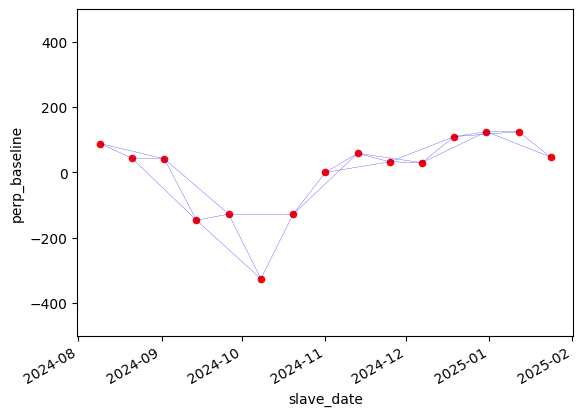

In [103]:
ax = df[df["master_date"]==zero_reference_date].plot.scatter(
    x='slave_date',
    y='perp_baseline',
    color="red",
    ylim=(-500, 500))
for x in df_filtered.index:
    single = df_filtered.iloc[[x]]
    point_1 = df[np.bitwise_and(df["master_date"]==zero_reference_date,np.bitwise_or(df["slave_date"]==single["master_date"].values[0],df["slave_date"]==single["slave_date"].values[0]))]
    ax = point_1.plot.line(
            x='slave_date',
            y='perp_baseline',
            legend=False,
            ax=ax,
            color="blue",
            linewidth=0.1)
plt.show()

Create date pairs list, used as input to the SNAP workflow:

In [104]:
def reformat_date_string(date):
    return date[:4] + date[5:7] + date[8:10]
sbas_dates_list = [f"{reformat_date_string(str(df_filtered.iloc[[x]]['master_date'].values[0]))}_{reformat_date_string(str(df_filtered.iloc[[x]]['slave_date'].values[0]))}" for x in df_filtered.index]
sbas_dates_list

['20240821_20240821',
 '20240821_20240902',
 '20240821_20240809',
 '20240821_20240914',
 '20240902_20240821',
 '20240902_20240902',
 '20240902_20240809',
 '20240902_20240914',
 '20240902_20240926',
 '20240809_20240821',
 '20240809_20240902',
 '20240809_20240809',
 '20240914_20240821',
 '20240914_20240902',
 '20240914_20240914',
 '20240914_20240926',
 '20240914_20241008',
 '20240926_20240902',
 '20240926_20240914',
 '20240926_20240926',
 '20240926_20241008',
 '20240926_20241020',
 '20250112_20250112',
 '20250112_20250124',
 '20250112_20241219',
 '20250112_20241231',
 '20250124_20250112',
 '20250124_20250124',
 '20250124_20241231',
 '20241008_20240914',
 '20241008_20240926',
 '20241008_20241008',
 '20241008_20241020',
 '20241020_20240926',
 '20241020_20241008',
 '20241020_20241020',
 '20241020_20241101',
 '20241020_20241113',
 '20241101_20241020',
 '20241101_20241101',
 '20241101_20241113',
 '20241101_20241125',
 '20241113_20241020',
 '20241113_20241101',
 '20241113_20241113',
 '20241113

Plot the graph showing the existing connections for a single reference date after the filtering:

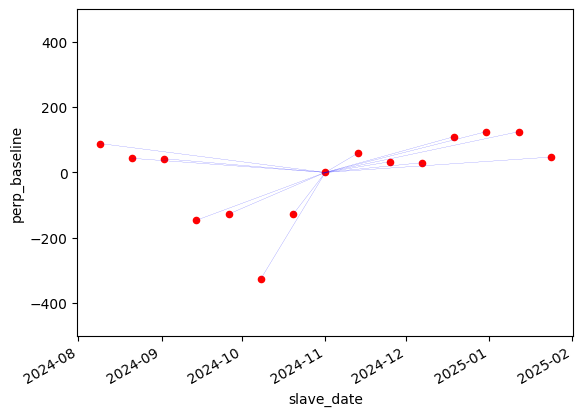

In [81]:
df_filtered_ = df[df["master_date"]==zero_reference_date].reset_index()
ax = df[df["master_date"]==zero_reference_date].plot.scatter(
    x='slave_date',
    y='perp_baseline',
    color="red",
    ylim=(-500, 500))
for x in df_filtered_.index:
    single = df_filtered_.iloc[[x]]
    point_1 = df[np.bitwise_and(df["master_date"]==zero_reference_date,np.bitwise_or(df["slave_date"]==single["master_date"].values[0],df["slave_date"]==single["slave_date"].values[0]))]
    ax = point_1.plot.line(
            x='slave_date',
            y='perp_baseline',
            legend=False,
            ax=ax,
            color="blue",
            linewidth=0.1)
plt.show()

Create date pairs list, used as input to the SNAP workflow:

In [101]:
ps_dates_list = [f"{reformat_date_string(str(df_filtered_.iloc[[x]]['master_date'].values[0]))}_{reformat_date_string(str(df_filtered_.iloc[[x]]['slave_date'].values[0]))}" for x in df_filtered_.index]
ps_dates_list

['20241101_20240821',
 '20241101_20240902',
 '20241101_20240809',
 '20241101_20240914',
 '20241101_20240926',
 '20241101_20250112',
 '20241101_20250124',
 '20241101_20241008',
 '20241101_20241020',
 '20241101_20241101',
 '20241101_20241113',
 '20241101_20241125',
 '20241101_20241207',
 '20241101_20241219',
 '20241101_20241231']